In [1]:
import numpy as np
import re
import pandas as pd
from scrapy.selector import Selector
from selenium import webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
driver = webdriver.Chrome('chromedriver.exe')
url = 'https://www.imdb.com/title/tt10168312/reviews?ref_=tt_urv'
time.sleep(1)
driver.get(url)
time.sleep(1)

In [3]:
sel = Selector(text = driver.page_source)
review_counts = sel.css('.lister .header span::text').extract_first().replace(',','').split(' ')[0]
more_review_pages = int(int(review_counts)/25)

In [4]:
for i in tqdm(range(more_review_pages)):
    try:
        css_selector = 'load-more-trigger'
        driver.find_element(By.ID, css_selector).click()
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 54.60it/s]


In [5]:
reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')
first_review = reviews[0]
sel2 = Selector(text = first_review.get_attribute('innerHTML'))
rating = sel2.css('.rating-other-user-rating span::text').extract_first().strip()

In [6]:
review_list = []
reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')

for d in tqdm(reviews):
    try:
        sel2 = Selector(text = d.get_attribute('innerHTML'))
        try:
            review = sel2.css('.text.show-more__control::text').extract_first()
        except:
            review = np.NaN
        review_list.append(review)
    except Exception as e:
        error_url_list.append(url)
        error_msg_list.append(e)
review_df = pd.DataFrame({
    'Review':review_list
    })

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 71.93it/s]


In [7]:
review_df.head()

,Review
0,"Now that the first season is over, I can confi..."
1,This is fun. I am enjoying every story.
2,A brilliant concept and a great way to view so...
3,Really enjoying this series & the risks they'v...
4,"Six episodes in, I have yet to be entertained ..."


In [8]:
def cleanReview(text):
    text = re.sub('@[A-Za-z0-9_]+', '', text)
    text = re.sub('#','',text)
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    return text

In [9]:
review_df['CleanedReview'] = review_df['Review'].apply(cleanReview)
review_df.head()

,Review,CleanedReview
0,"Now that the first season is over, I can confi...","Now that the first season is over, I can confi..."
1,This is fun. I am enjoying every story.,This is fun. I am enjoying every story.
2,A brilliant concept and a great way to view so...,A brilliant concept and a great way to view so...
3,Really enjoying this series & the risks they'v...,Really enjoying this series & the risks they'v...
4,"Six episodes in, I have yet to be entertained ...","Six episodes in, I have yet to be entertained ..."


In [10]:
review_df.to_csv('File.csv')

In [11]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
plt.style.use('fivethirtyeight')
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import spacy
nlp = spacy.load("en_core_web_sm")
from textblob import TextBlob
from wordcloud import WordCloud
from datetime import date

In [12]:
Clean_review = review_df[['CleanedReview']]
Clean_review

,CleanedReview
0,"Now that the first season is over, I can confi..."
1,This is fun. I am enjoying every story.
2,A brilliant concept and a great way to view so...
3,Really enjoying this series & the risks they'v...
4,"Six episodes in, I have yet to be entertained ..."
...,...
463,Episode with zombies is the best. I'm waiting ...
464,Don't know why but this what if tv series epis...
465,What if... ? Is a Marvel American series. It w...
466,I think making some of these episodes pretty m...


In [13]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [14]:
Clean_review['Subjectivity'] = Clean_review['CleanedReview'].apply(getSubjectivity)
Clean_review['Polarity'] = Clean_review['CleanedReview'].apply(getPolarity)

In [15]:
Clean_review.head()

,CleanedReview,Subjectivity,Polarity
0,"Now that the first season is over, I can confi...",0.517708,0.232031
1,This is fun. I am enjoying every story.,0.400000,0.400000
2,A brilliant concept and a great way to view so...,0.651754,0.213377
3,Really enjoying this series & the risks they'v...,0.800000,0.300000
4,"Six episodes in, I have yet to be entertained ...",0.863095,-0.370238


In [16]:
def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score ==0:
        return 'Neutral'
    else:
        return 'Positive'

In [17]:
def getFactuality(score):
    if abs(score - 0) < 0.5:
        return "Factual"
    if abs(score - 1) < 0.5:
        return "Personal"

In [18]:
Clean_review['Rating'] = Clean_review['Polarity'].apply(getAnalysis)

In [19]:
Clean_review['Sentiment'] = Clean_review['Subjectivity'].apply(getFactuality)

In [20]:
Clean_review.head()

,CleanedReview,Subjectivity,Polarity,Rating,Sentiment
0,"Now that the first season is over, I can confi...",0.517708,0.232031,Positive,Personal
1,This is fun. I am enjoying every story.,0.400000,0.400000,Positive,Factual
2,A brilliant concept and a great way to view so...,0.651754,0.213377,Positive,Personal
3,Really enjoying this series & the risks they'v...,0.800000,0.300000,Positive,Personal
4,"Six episodes in, I have yet to be entertained ...",0.863095,-0.370238,Negative,Personal


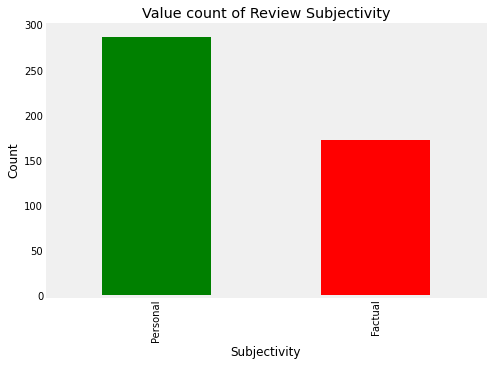

In [21]:
fig = plt.figure(figsize=(7,5))
color = ['green','red']
Clean_review['Sentiment'].value_counts().plot(kind='bar',color = color)
plt.title('Value count of Review Subjectivity')
plt.ylabel('Count')
plt.xlabel('Subjectivity')
plt.grid(False)
plt.show()

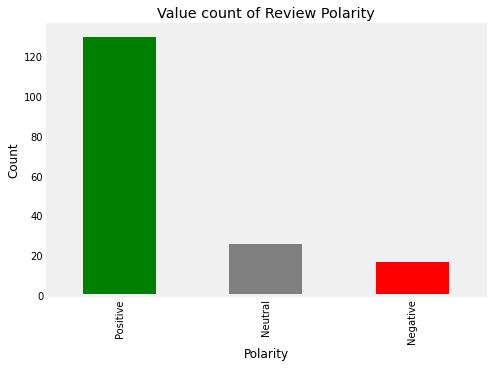

In [22]:
fig = plt.figure(figsize=(7,5))
color = ['green','grey','red']
Clean_review['Rating'][Clean_review['Sentiment']=='Factual'].value_counts().plot(kind='bar',color = color)
plt.title('Value count of Review Polarity')
plt.ylabel('Count')
plt.xlabel('Polarity')
plt.grid(False)
plt.show()

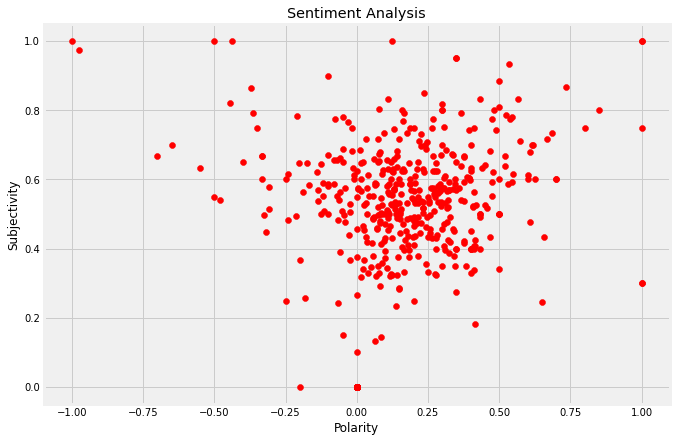

In [23]:
plt.figure(figsize=(10,7))
for i in range(0,Clean_review.shape[0]):
    plt.scatter(Clean_review['Polarity'][i],Clean_review['Subjectivity'][i], color='red')
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [24]:
def create_wordcloud(text):    
    allWords = ' '.join([tweets for tweets in text])
    wordCloud = WordCloud(background_color='white', 
                          width=800,
                          height=500, 
                          random_state=21,
                          max_font_size=130).generate(allWords)
    plt.figure(figsize=(20,10))
    plt.imshow(wordCloud)
    plt.axis('off')
    plt.show()

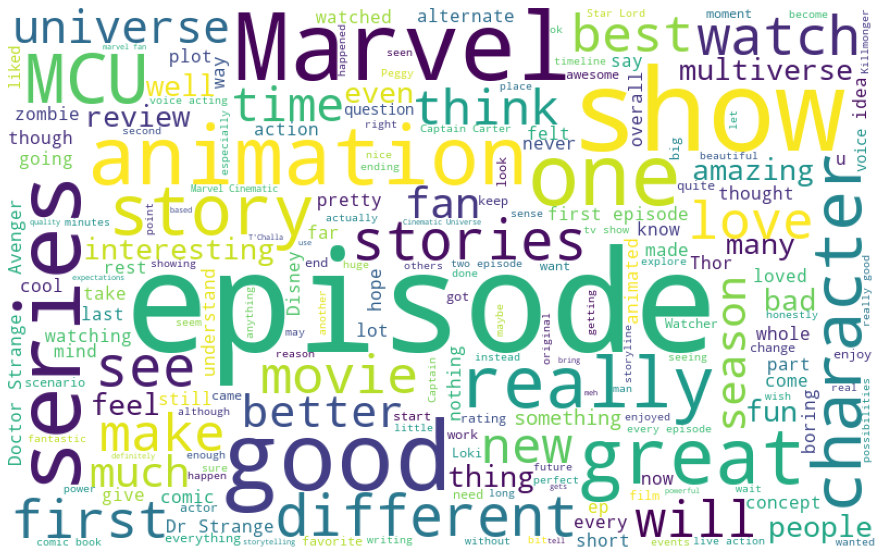

In [25]:
Positive_Review = Clean_review.loc[Clean_review['Rating']=='Positive','CleanedReview']
create_wordcloud(Positive_Review)

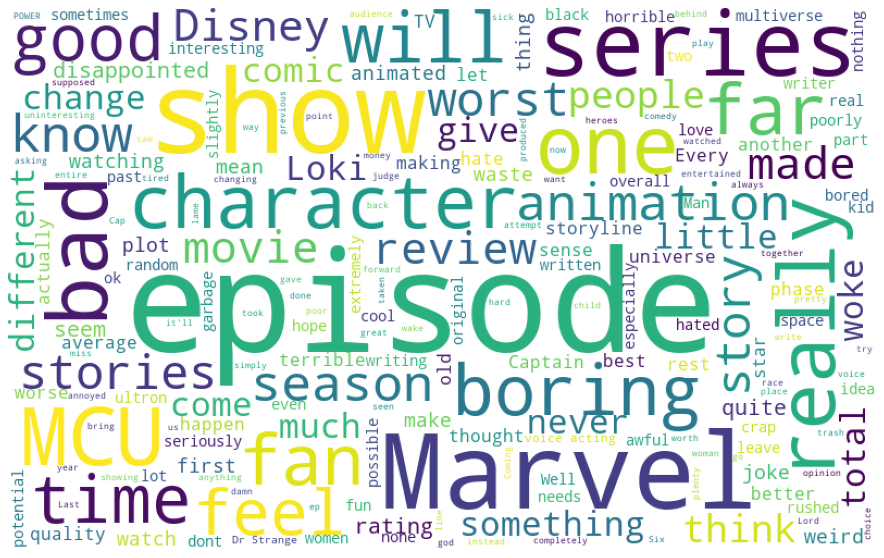

In [26]:
Negative_Review = Clean_review.loc[Clean_review['Rating']=='Negative','CleanedReview']
create_wordcloud(Negative_Review)

In [27]:
sentences = []
for word in Clean_review['CleanedReview']:
    sentences.append(word)
    
lines = list()
for line in sentences:
    words = line.split()
    for w in words:
        lines.append(w)
lines[:10]

['Now',
 'that',
 'the',
 'first',
 'season',
 'is',
 'over,',
 'I',
 'can',
 'confidently']

In [28]:
stemmer = SnowballStemmer(language='english')
stem=[]
for word in lines:
    stem.append(stemmer.stem(word))
stem[:20]

['now',
 'that',
 'the',
 'first',
 'season',
 'is',
 'over,',
 'i',
 'can',
 'confid',
 'say',
 'that',
 'this',
 'seri',
 'has',
 'exceed',
 'my',
 'expectations.',
 'it',
 'use']

In [29]:
stem2 = []
for word in stem:
    if word not in nlp.Defaults.stop_words:
        stem2.append(word)

In [30]:
df = pd.DataFrame(stem2)
df=df[0].value_counts()
df

episod       343
marvel       168
like         148
anim         127
good         121
            ... 
if?"           1
question:      1
unknown,       1
guid           1
filler.        1
Name: 0, Length: 3416, dtype: int64

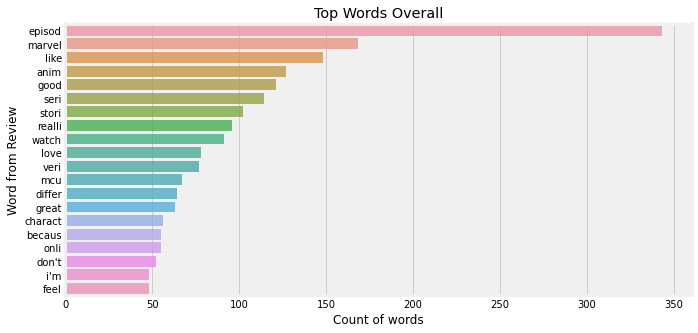

In [31]:
df = df[:20]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top Words Overall')
plt.xlabel('Count of words', fontsize=12)
plt.ylabel('Word from Review', fontsize=12)
plt.show()